In [1]:
# Get target list; this follows the selection in ../document/figures/targets.py 
import sys
sys.path.append('..')

from peerless.catalogs import KICatalog, KOICatalog, EBCatalog, BlacklistCatalog
import numpy as np

stlr = KICatalog().df
m = (4200 <= stlr.teff) & (stlr.teff <= 6100)
m &= stlr.radius <= 1.15
m &= stlr.dataspan > 365.25*2.
m &= stlr.dutycycle > 0.6
m &= stlr.rrmscdpp07p5 <= 1000.
m &= stlr.kepmag < 15.

# known EBs
ebs = set(np.array(EBCatalog().df["#KIC"]))

# KOI false positives
kois = KOICatalog().df
kois = kois[kois.koi_disposition == "FALSE POSITIVE"]
fps = set(np.array(kois.kepid))

# And then finally the blacklist.
bl = set(np.array(BlacklistCatalog().df.kicid))

# The full list of ignores.
ignore = fps | bl #ebs | fps | bl  #Don't ignore EBs for purposes of prediction
m &= ~stlr.kepid.isin(ignore)

targets = stlr[m]

In [2]:
targets[['kepid','mass','feh']].count()

kepid    39626
mass     38983
feh      39626
dtype: int64

In [3]:
# funny, there seem to be some missing masses.  Let's artificially add those in, with M=R
bad = targets.mass.isnull()
targets.loc[bad, 'mass'] = targets.loc[bad, 'radius']

/u/tdm/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:415: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [4]:
# Simulation a population of binary stars and observe them.

from sims import BinaryPopulation
ebs = BinaryPopulation(targets)
obs = ebs.observe(query='period > 5')[['period','d_pri','d_sec','T14_pri','T14_sec',
                                                             'b_pri','b_sec','k','n_pri','n_sec',
                                                                   'radius_A','radius_B','flux_ratio',
                                        'dutycycle']]
len(obs)

/u/tdm/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:249: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


217

OK, this is how many EBs we predict there to be with periods greater than 5 days.  How does this compare with the actual EB catalog?

In [9]:
# Total number of Kepler EBs with P > 5, scaled by number of targets
from __future__ import division
len(EBCatalog().df.query('period>5')) * (len(targets)/len(KICatalog().df))

224.75436655536478

OK, this is creepy-close.  But this is very encouraging.  Means we should be able to take seriously the results of this simulation.  What does it say about single/double eclipses (either only primary or only secondary)?

In [6]:
candidates = obs.query('((n_pri + n_sec) < 3) and (n_pri==0 or n_sec==0)')
candidates

,period,d_pri,d_sec,T14_pri,T14_sec,b_pri,b_sec,k,n_pri,n_sec,radius_A,radius_B,flux_ratio,dutycycle
4275,1002.011194,0.000000,0.103874,0.000000,0.241317,10.570425,1.025644,0.688012,0,1,0.886,0.609578,0.343562,0.6989
13215,620.308117,0.000000,0.077289,0.000000,0.112696,20.046438,1.210222,0.863486,0,2,0.958,0.827219,0.408770,0.8750
16691,4787.278353,0.446244,0.100880,1.512231,1.604964,0.543839,0.581393,0.796694,0,1,0.881,0.701887,0.151157,0.6988
65781,1350.237797,0.000000,0.387652,0.000000,0.462423,2.369126,0.382477,1.000000,0,1,0.916,0.916000,0.954337,0.8752
72111,1557.348509,0.294107,0.130596,0.916945,0.930755,0.742573,0.756988,0.757564,0,1,0.914,0.692413,0.257859,0.6989
76477,2593.700323,0.300404,0.031946,0.971452,1.458108,0.559297,1.038411,0.588197,0,1,0.978,0.575257,0.087313,0.6988
98500,865.573230,0.000000,0.198378,0.561032,0.621218,1.698241,0.938492,0.883753,0,1,0.867,0.766214,0.775737,0.8744
118317,571.181697,0.407305,0.000000,0.212031,0.000000,0.535221,8.500014,0.952129,2,0,0.886,0.843587,0.607486,0.8750
122685,1313.712398,0.085964,0.000000,0.212197,0.000000,0.711073,2.195621,0.295115,2,0,0.770,0.227239,0.005817,0.8753


Let's look at the depth vs. duration for these signals.

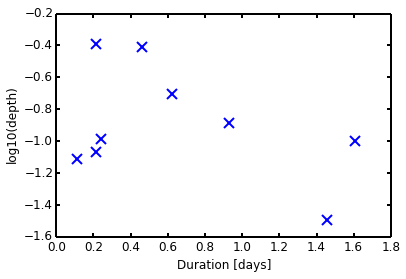

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

pri = candidates.n_pri > 0
sec = candidates.n_sec > 0

depth = pri*candidates.d_pri + sec*candidates.d_sec
duration = pri*candidates.T14_pri + sec*candidates.T14_sec

plt.plot(duration, np.log10(depth), 'x', ms=10);
plt.xlabel('Duration [days]')
plt.ylabel('log10(depth)')